
##  Clustering on EarthQuake Data


In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:
#import statements
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import datetime as dt

#sklearn imports
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


In [254]:
#import dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Omdena turkey/Omdena_Turkey__final_rev1.csv", index_col=0)

#display first five rows
df.head()


,Latitude,Longitude,Depth(km),xM,MD,ML,Mw,Ms,Mb,Type,Location,City,AREA_,geometry,Date_Time,Year,Month,Hour
0,37.8,29.1,5.0,5.0,5.0,0.0,NaN,0.0,0.0,1,DENIZLI (DENIZLI) [North East 2.3 km],DENIZLI,4621.875,POINT (29.1 37.8),1900-09-20 00:00:01.000,1900,9,0
1,37.8,29.1,20.0,4.9,4.8,4.8,4.9,4.8,4.9,1,DENIZLI (DENIZLI) [North East 2.3 km],DENIZLI,4621.875,POINT (29.1 37.8),1904-01-01 11:38:00.000,1904,1,11
2,37.8,28.7,30.0,5.5,5.2,5.2,5.5,5.3,5.2,1,HACIHIDIRLAR-KARACASU (AYDIN) [North East 2.9...,AYDIN,2866.059,POINT (28.7 37.8),1910-08-07 21:45:00.000,1910,8,21
3,37.5,29.0,15.0,4.5,4.5,0.0,NaN,0.0,0.0,1,MEDET-TAVAS (DENIZLI) [South West 1.7 km],DENIZLI,4621.875,POINT (29 37.5),1920-07-02 14:13:01.000,1920,7,14
4,37.5,29.0,15.0,5.3,5.0,4.9,5.3,5.0,5.0,1,MEDET-TAVAS (DENIZLI) [South West 1.7 km],DENIZLI,4621.875,POINT (29 37.5),1920-07-04 12:17:58.000,1920,7,12


In [255]:
df.shape

(43432, 18)

We have city names all capitalized. Since we are going to use geopandas , folium and choropleth maps, we will format the city names with only first letter capital to match with the geojson city names format. 

In [256]:
df['City'] = df.City.str.lower().str.capitalize()

In [257]:
#creating a geodataframe 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

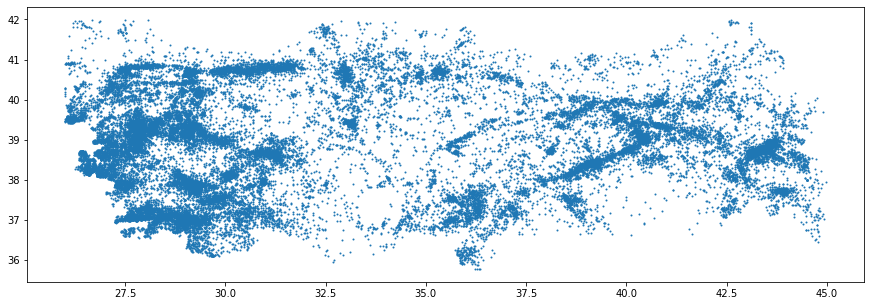

In [258]:
#plotting the locations of each earthquake that has occured
gdf.plot(figsize=(15,10), markersize=1)

Lets get the idea about null values in our data

In [259]:
gdf.isnull().sum()

Latitude         0
Longitude        0
Depth(km)        0
xM               0
MD               0
ML               0
Mw           37659
Ms               0
Mb               0
Type             0
Location         0
City             0
AREA_            0
geometry         0
Date_Time        0
Year             0
Month            0
Hour             0
dtype: int64

We see that only Mw has more than 37000 missing values which we can drop from our data to proceed with clustering. It is not statistically feasible to fill these many amount of missing values. 

Below you can see the interpretation of each column.

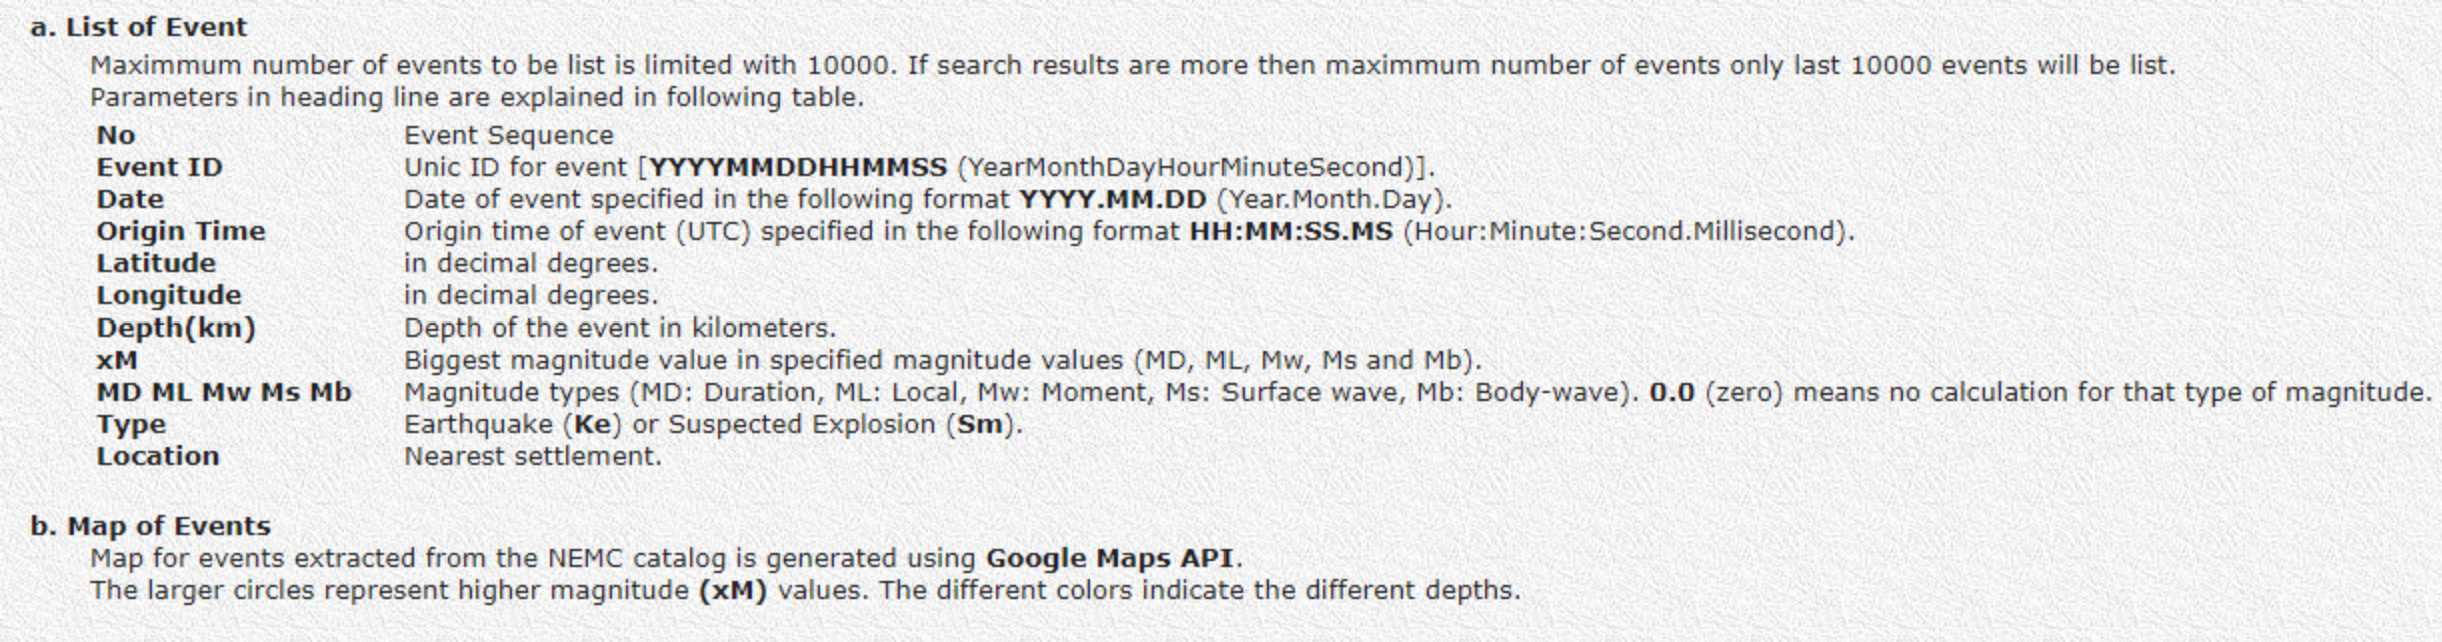

## Standard Scaling the data

In [260]:
#creating a standard scaler instance
scale = StandardScaler()

#applying the dataframe to fit and transform
lat_long_df = scale.fit_transform(gdf[['Latitude','Longitude','xM']])

In [261]:
#check the array
lat_long_df

array([[-0.86893713, -0.6937641 ,  3.36651406],
       [-0.86893713, -0.6937641 ,  3.15948858],
       [-0.86893713, -0.76565879,  4.40164147],
       ...,
       [-1.3544313 ,  1.76611265,  0.26113182],
       [ 1.58138842, -0.79741827, -0.7739956 ],
       [ 0.44352721,  2.06977783, -0.15291915]])

Now, the general idea is to use Kmeans algorithm and find the best number of clusters based on the elbow method. 

In [262]:

def cluster_find(df):
  inertia = []
  cluster = []
  for k in range(2,25):
    kmean = KMeans(n_clusters =k, random_state=20).fit(df)
    inertia.append(kmean.inertia_)
    cluster.append(k)


  plt.plot(cluster, inertia)
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")
  plt.title("Finding the Best value of K Cluster")



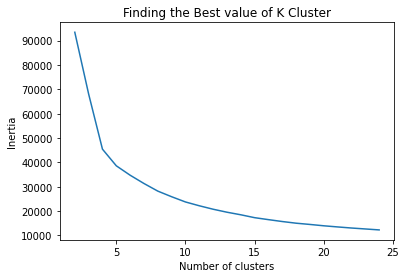

In [263]:
#get the eblow curve for above cluster columns selected 
cluster_find(lat_long_df)

From above curve the elbow is not very evident from the shape, but we can take the k number to be 5 as we can classify that many categories of earthquake depending on the magnitude. 

In [264]:
#creating a clustering model based on n clusters
kmean = KMeans(n_clusters =4, random_state=20).fit(lat_long_df)

In [265]:
lat_long_df = pd.DataFrame(lat_long_df, columns=['Latitude','Longitude','xM'])

lat_long_df

,Latitude,Longitude,xM
0,-0.868937,-0.693764,3.366514
1,-0.868937,-0.693764,3.159489
2,-0.868937,-0.765659,4.401641
3,-1.121011,-0.711738,2.331387
4,-1.121011,-0.711738,3.987591
...,...,...,...
43427,1.933704,1.112320,-0.359945
43428,1.679277,-0.943185,0.261132
43429,-1.354431,1.766113,0.261132
43430,1.581388,-0.797418,-0.773996


In [266]:
#getting a column with all the labels into our geodataframe
lat_long_df['clusters'] = kmean.fit_predict(lat_long_df)
df['clusters'] = kmean.fit_predict(lat_long_df)


In [267]:
#checking the value coutns for all 
df['clusters'].value_counts()

2    15170
0    13585
1    11001
3     3676
Name: clusters, dtype: int64

In [268]:
#also get cluster centroids

cen1 = kmean.cluster_centers_

In [269]:
cen1

array([[-1.02819161e+00, -5.44734265e-01, -2.29938420e-01,
         3.00000000e+00],
       [ 7.77870516e-02,  1.41452847e+00, -1.87263437e-01,
        -9.03721542e-14],
       [ 8.42274932e-01, -5.89653265e-01, -2.98996986e-01,
         2.00000000e+00],
       [ 9.11145054e-02,  2.13282739e-01,  2.64406496e+00,
         1.00000000e+00]])

We will do some analysis on how these categories are distributed based on magnitude of earthquake.

In [270]:
map_turkey = gpd.read_file("https://raw.githubusercontent.com/deldersveld/topojson/master/countries/turkey/turkiye.json")

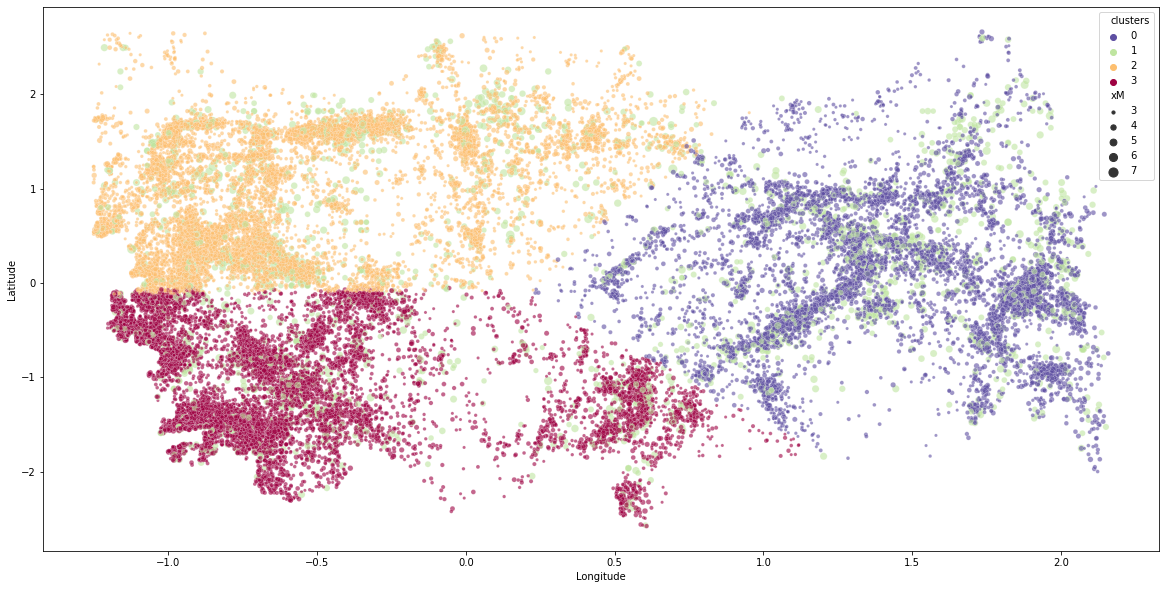

In [271]:
fig, ax=  plt.subplots(figsize=(20,10))

#plotting the map of turkey
#map_turkey.plot(column='NAME1_',figsize=(30,30), cmap='cubehelix')
sns.scatterplot(x=lat_long_df.Longitude, y=lat_long_df.Latitude, hue=lat_long_df['clusters'], size=df.xM, sizes=(10,100),palette='Spectral_r', alpha=0.6,)
#plt.scatter(cen1[1],cen1[0])

Lets try to plot these in a folium map

In [272]:
df_new = df.groupby('City').mean().reset_index()

df_new['xM'].min()

3.142857142857143

In [273]:
df_new.replace('Kirklareli','Kırklareli')
df_new.replace('Tekirdag','Tekirdağ')
df_new.replace('Canakkale','Çanakkale')
df_new.replace('Istanbul','İstanbul')
df_new.replace('Balikesir','Balıkesir')
df_new.replace('Izmir','İzmir')
df_new.replace('Aydin','Aydın')
df_new.replace('Mugla','Muğla')
df_new.replace('Kutahya','Kütahya')
df_new.replace('Usak','Uşak')
df_new.replace('Afyonkarahisar','Afyon')
df_new.replace('Eskisehir','Eskişehir')
df_new.replace('Duzce','Düzce')
df_new.replace('Bartin','Bartın')
df_new.replace('Karabuk','Karabük')
df_new.replace('Cankiri','Çankırı')
df_new.replace('Corum','Çorum')
df_new.replace('Kirikkale','Kırıkkale')
df_new.replace('Kirsehir','Kırşehir')
df_new.replace('Nevsehir','Nevşehir')
df_new.replace('Nigde','Niğde')
df_new.replace('Kahramanmaras','Kahramanmaraş')
df_new.replace('Adiyaman','Adıyaman')
df_new.replace('Sanliurfa','Şanlıurfa')
df_new.replace('Diyarbakir','Diyarbakır')
df_new.replace('Elazig','Elazığ')
df_new.replace('Bingol','Bingöl')
df_new.replace('Mus','Muş')
df_new.replace('Sirnak','Şırnak')
df_new.replace('Agri','Ağrı')
df_new.replace('Igdir','Iğdır')
df_new.replace('Gumushane','Gümüşhane')


,City,Latitude,Longitude,Depth(km),xM,MD,ML,Mw,Ms,Mb,Type,AREA_,Year,Month,Hour,clusters
0,Adana,37.295263,35.678343,13.566612,3.398371,2.571498,0.868893,3.311842,0.093160,0.218567,1.000000,5329.6250,2005.289902,6.644951,11.705212,0.288274
1,Adiyaman,37.791861,38.360885,10.650156,3.493769,1.986293,1.528037,3.306195,0.215888,0.466667,1.000000,2923.4540,2006.059190,5.657321,11.616822,1.299065
2,Afyonkarahisar,38.488994,30.659881,6.674078,3.297523,2.927765,0.262327,4.155738,0.102880,0.369240,1.000000,5760.0350,1997.193548,6.338134,11.636521,0.537442
3,Agri,39.591220,43.390729,10.450575,3.577778,2.298467,1.282759,3.955556,0.231418,0.684674,1.000000,4067.9580,2003.268199,6.176245,12.747126,1.314176
4,Aksaray,38.362202,33.886012,8.124000,3.414000,2.264000,1.218000,3.800000,0.098000,0.098000,1.000000,3097.2690,2007.420000,6.600000,10.560000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Usak,38.683350,29.439773,10.736800,3.570400,2.816000,1.076800,4.665385,0.886400,1.501600,1.000000,2110.4580,1983.392000,5.648000,10.536000,1.352000
77,Van,38.659974,43.485298,7.186269,3.448095,0.825449,2.650611,3.472280,0.088354,0.330230,1.000000,7238.1760,2009.876707,7.966571,11.905464,1.191229
78,Yalova,40.643288,29.105380,8.171259,3.297150,2.517577,0.631116,2.968889,0.028266,0.230404,0.992874,483.1972,2001.171021,7.282660,11.983373,2.054632
79,Yozgat,39.725041,35.386025,9.937255,3.381373,2.699020,0.906863,4.135714,0.363725,0.469608,0.970588,5462.6670,2001.323529,6.235294,11.176471,1.901961


In [274]:
import folium
m = folium.Map(location=[38.9637, 35.2433], zoom_start=6)


state_geo ="https://raw.githubusercontent.com/alpers/Turkey-Maps-GeoJSON/master/tr-cities.json"
#state_unemployment = f"{url}/US_Unemployment_Oct2012.csv"
#state_data = pd.read_csv(state_unemployment)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=df_new,
    columns=['City','xM'],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="xM",
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],  # use fields from the json file
        aliases=['State: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
).add_to(m)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    state_geo ,
    
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['Province: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)
m

In [275]:
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [276]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
Latitude = "37.8000"
Longitude = "28.7000"
 
location = geolocator.reverse(Latitude+","+Longitude)
 
# Display
location.raw['address']

{'ISO3166-2-lvl4': 'TR-09',
 'country': 'Türkiye',
 'country_code': 'tr',
 'county': 'Karacasu',
 'province': 'Aydın',
 'region': 'Ege Bölgesi',
 'village': 'Hacıhıdırlar'}